## Линейные и ансамблевые методы

### Обучение модели

Подключаемые модули

In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

Подгрузка данных о доменных именах с диска 

In [3]:
with open('input data/training_data.pkl', 'rb') as f:
        training_data = pickle.load(f)

Общая коллекция данных

In [4]:
all_data_dict = pd.concat([training_data['legit'], training_data['dga']], ignore_index=True)

Подсчет длин доменных имен (legit, dga)

In [5]:
all_data_dict['length'] = [len(x) for x in all_data_dict['domain']]

Отброс записей с длиной < 6

In [6]:
# Поскольку результаты классификации для таких доменов показывают близкие результаты 
# и в DGA-доменах нет записей с длиной < 6, в модели такие записи не будут учитываться
all_data_dict = all_data_dict[all_data_dict['length'] > 6]

Создание модели для матрицы подсчета n-gram

In [7]:
# Минимальная частота = 0,001% для всех доменов
# Для 0,01% появляется много нулевых значений вхождений n-gram
vectorizer = CountVectorizer(ngram_range=(3, 5), analyzer='char', min_df=1e-3, max_df=1.0)

Подсчет вхождений n-gram в legit (создание словаря n-gram)

In [8]:
# Результат в разреженной матрице (большинство вхождений нули)
# "(x,y) n" означает "(строка, столбец) значение"
# n - количество раз, когда в доменах появилась отдельная n-gram
ngram_matrix = vectorizer.fit_transform(training_data['legit']['domain'])

In [9]:
# Преобразование в плотную матрицу (сумма столбца),
# затем в многомерный однородный массив
ngram_counts = ngram_matrix.sum(axis=0).getA1()

Подсчет вхождений n-gram в каждый домен коллекции

In [10]:
# Соотношение доменного имени коллекции (разреженой транспонированной матрицы)
# с массивом ngram_count (словарь) путем умножения векторов
all_data_dict['occur_ngrams'] = ngram_counts * vectorizer.transform(all_data_dict['domain']).transpose()

Массивы обучения

In [11]:
# Массив x хранит образцы обучения
# В массиве y хранятся целевые значения (метки типов) для образцов обучения
X = all_data_dict[['length', 'occur_ngrams']].values
y = np.array(all_data_dict['type'].tolist())

### Тестирование

In [12]:
from sklearn.model_selection import cross_val_score, train_test_split

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

In [14]:
models = [LogisticRegression(solver='lbfgs'), RandomForestClassifier(n_estimators=20),
          GaussianNB(), DecisionTreeClassifier(), ExtraTreesClassifier(n_estimators=20)]

In [15]:
names = ["Logistic Regression", "Random Forest", "Naive Bayes", "Decision Tree", "Extra Trees"]

#### Кросс-валидация (cross-validation)

In [16]:
for model, name in zip(models, names):
    print(name)
    for score in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
        print(score, " : ", cross_val_score(model, X, y, scoring=score, cv=10).mean())
    print("\n")

Logistic Regression


accuracy  :  0.6938783719650254


precision  :  0.6831276254116386


recall  :  0.9205260255615031


f1  :  0.7825943990437525


roc_auc  :  0.8247175887699184


Random Forest


accuracy  :  0.8925805619554865


precision  :  0.9185672058686561


recall  :  0.9032726598190731


f1  :  0.9091905243144451


roc_auc  :  0.9390293541633445


Naive Bayes


accuracy  :  0.6349563635601466


precision  :  0.637816073914329


recall  :  0.9130875301214252


f1  :  0.7497202418300947


roc_auc  :  0.7115674046705571


Decision Tree


accuracy  :  0.8902514468634617


precision  :  0.9206695712164299


recall  :  0.8966838511921184


f1  :  0.9069938816403796


roc_auc  :  0.906893478493506


Extra Trees


accuracy  :  0.8910670302428512


precision  :  0.9207693538942404


recall  :  0.8979081508769692


f1  :  0.9076663245086612


roc_auc  :  0.9267344867373785




#### Отложенная выборка (held-out/hold-out set)

In [17]:
# 20% для теста
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, \
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from itertools import product


In [19]:
modelLR = LogisticRegression(solver='lbfgs')
modelLR.fit(X_train, y_train)
y_predLR = modelLR.predict(X_test)
y_scoreLR = modelLR.predict_proba(X_test)[:, 1]

modelRF = RandomForestClassifier(n_estimators=20)
modelRF.fit(X_train, y_train)
y_predRF = modelRF.predict(X_test)
y_scoreRF = modelRF.predict_proba(X_test)[:, 1]

modelNB = GaussianNB()
modelNB.fit(X_train, y_train)
y_predNB = modelNB.predict(X_test)
y_scoreNB = modelNB.predict_proba(X_test)[:, 1]

modelDT = DecisionTreeClassifier()
modelDT.fit(X_train, y_train)
y_predDT = modelDT.predict(X_test)
y_scoreDT = modelDT.predict_proba(X_test)[:, 1]

modelET = ExtraTreesClassifier(n_estimators=20)
modelET.fit(X_train, y_train)
y_predET = modelET.predict(X_test)
y_scoreET = modelET.predict_proba(X_test)[:, 1]

In [20]:
y_pred = [y_predLR, y_predRF, y_predNB, y_predDT, y_predET]
y_score = [y_scoreLR, y_scoreRF, y_scoreNB, y_scoreDT, y_scoreET]
labels = ['legit', 'dga']

Метрика точности (precision) 

In [21]:
print("Precision score")
for y_pr, name in zip(y_pred, names):
    print(name, " : ", precision_score(y_test, y_pr))

Precision score
Logistic Regression  :  0.6897609348098109
Random Forest  :  0.9251899288520491
Naive Bayes

  :  0.647215089385896
Decision Tree  :  0.9272666803110929
Extra Trees  :  0.9272457786835498


Метрика полноты (recall) 

In [22]:
print("Recall score")
for y_pr, name in zip(y_pred, names):
    print(name, " : ", recall_score(y_test, y_pr))

Recall score


Logistic Regression  :  0.9416373397724062
Random Forest  :  0.9361401525854761


Naive Bayes  :  0.9371933519997945


Decision Tree  :  0.9310539700480361
Extra Trees  :  0.9320750597241131

F-мера (среднее гармоническое точности и полноты)

In [23]:
print("F1 score")
for y_pr, name in zip(y_pred, names):
    print(name, " : ", f1_score(y_test, y_pr))

F1 score


Logistic Regression  :  0.7962551657100034
Random Forest  :  0.9306328305801612


Naive Bayes  :  0.7656683254678002


Decision Tree  :  0.929156465898458
Extra Trees  :  0.9296541475709623


Матрица ошибок (Confusion Matrix)

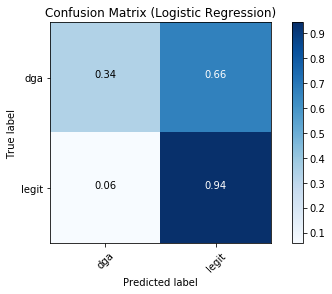

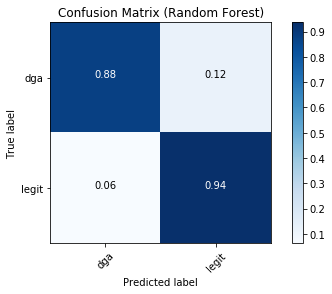

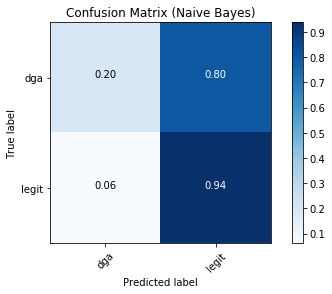

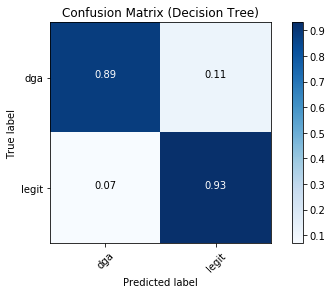

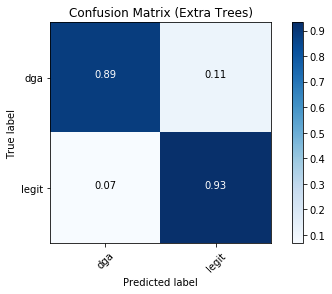

In [24]:
for y_pr, name in zip(y_pred, names):
    cm = confusion_matrix(y_test, y_pr)
    np.set_printoptions(precision=2)
    
    cm = cm.astype('float') / cm.sum(axis=1).T[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix (" + name + ")")
    plt.colorbar()
    plt.xticks([1, 0], labels, rotation=45)
    plt.yticks([1, 0], labels)
    
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

ROC-кривая 

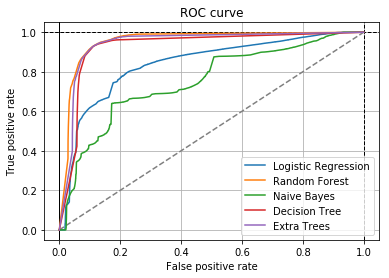

In [25]:
plt.figure()
plt.plot([0, 1], [0, 1], '--', color="grey")
plt.axvline(0, linestyle="-", c="black", lw=1)
plt.axvline(1, linestyle="--", c="black", lw=1)
plt.axhline(1, linestyle="--", c="black", lw=1)
for y_sc, name in zip(y_score, names):
    fpr, tpr, thresholds = roc_curve(y_test, y_sc)
    plt.plot(fpr, tpr, label=name)
plt.grid(True)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show() 

Показатель ROC AUC

In [26]:
print("ROC AUC score")
for y_sc, name in zip(y_score, names):
    print(name, " : ", roc_auc_score(y_test, y_sc))

ROC AUC score
Logistic Regression  :  0.8397871352196782
Random Forest  :  0.9541751536028023


Naive Bayes  :  0.7504953177041453
Decision Tree  :  0.9266335559820092
Extra Trees  :  0.9424370488458921


Кривая Точность-Полнота (Precision-Recall)

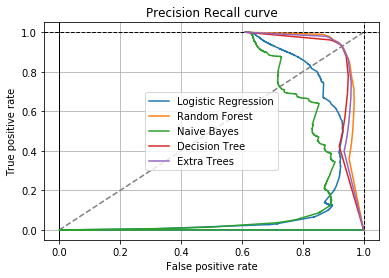

In [27]:
plt.figure()
plt.plot([0, 1], [0, 1], '--', color="grey")
plt.axvline(0, linestyle="-", c="black", lw=1)
plt.axvline(1, linestyle="--", c="black", lw=1)
plt.axhline(1, linestyle="--", c="black", lw=1)
for y_sc, name in zip(y_score, names):
    fpr, tpr, thresholds = precision_recall_curve(y_test, y_sc)
    plt.plot(fpr, tpr, label=name)
plt.grid(True)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Precision Recall curve')
plt.legend(loc='best')
plt.show()

Показатель средней точности (Average Precision)

In [28]:
print("Average Precision score")
for y_sc, name in zip(y_score, names):
    print(name, " : ", average_precision_score(y_test, y_sc))

Average Precision score
Logistic Regression  :  0.8607108621326318
Random Forest  :  0.950214077883853


Naive Bayes  :  0.800868298895979
Decision Tree  :  0.918420487348097
Extra Trees  :  0.9356063513093749
